In [1]:
import matplotlib.pyplot as plt
# from fiberpy import *
# from fiberoripy import *
from homopy.methods import *
from homopy.elasticity import *
from homopy.stiffness_plot import *

In [2]:
# define fiber and matrix properties
carbon_fiber = Isotropy(242e9, 0.1)
v_frac_carbon = 0.25
a_carbon = 347
glass_fiber = Isotropy(80e9, 0.22)
v_frac_glass = 0.25
a_glass = 225
polyamid6 = Isotropy(1.18e9, 0.35)

In [3]:
# Mori Tanaka
mt_carbon = MoriTanaka(polyamid6, carbon_fiber, v_frac_carbon, a_carbon)
mt_glass = MoriTanaka(polyamid6, glass_fiber, v_frac_glass, a_glass)
mt_hybrid = MoriTanaka(polyamid6, [carbon_fiber, glass_fiber], [v_frac_carbon/2, v_frac_glass/2], [a_carbon, a_glass])

# Extract effective stiffness
c_eff_carbon = mt_carbon.get_effective_stiffness()
c_eff_glass = mt_glass.get_effective_stiffness()
c_eff_hybrid = mt_hybrid.get_effective_stiffness()

# Invert to get effective compliance (needed for plotting)
s_eff_carbon = np.linalg.inv(c_eff_carbon)
s_eff_glass = np.linalg.inv(c_eff_glass)
s_eff_hybrid = np.linalg.inv(c_eff_hybrid)

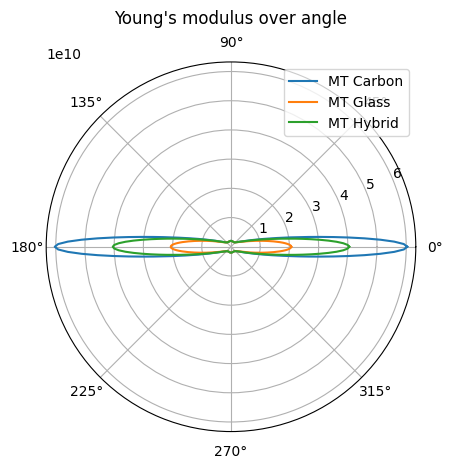

In [4]:
# polar plot of MT result
plotter = ElasticPlot(USEVOIGT=False) # we highly recommend using USEVOIGT=False

pC = plotter.polar_plot_E_body(s_eff_carbon, 400, 0, plot=False)
pG = plotter.polar_plot_E_body(s_eff_glass, 400, 0, plot=False)
pH = plotter.polar_plot_E_body(s_eff_hybrid, 400, 0, plot=False)

plotter.polar_plot(
    [pC + ("MT Carbon",), pG + ("MT Glass",), pH + ("MT Hybrid",)]
) 

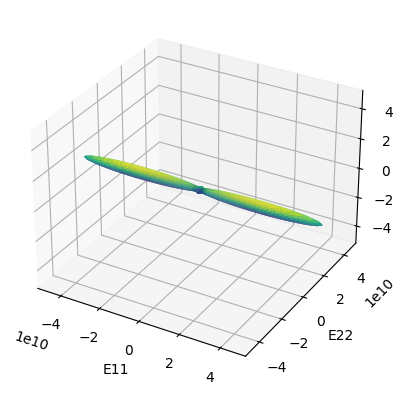

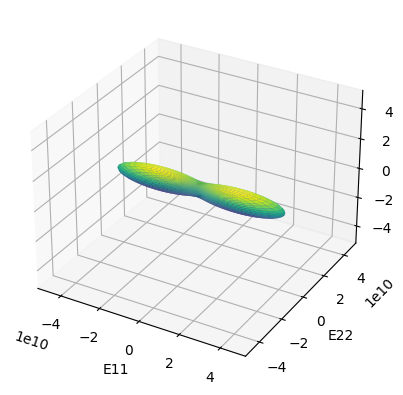

In [23]:
# Orientation averaging
from fiberoripy.closures import (
        IBOF_closure,
        compute_closure,
        hybrid_closure,
        linear_closure,
        quadratic_closure,
    )

N2 = np.eye(3)
N2[0, 0] = 26 / 32
N2[1, 1] = 3 / 32
N2[2, 2] = 3 / 32
N4 = IBOF_closure(N2) # recommended by the authors

c_eff_carbon_ave = mt_carbon.get_average_stiffness(c_eff_carbon, N2, N4)
s_eff_carbon_ave = np.linalg.inv(c_eff_carbon_ave)

# plot stiffness body of UD reinforcement...
plotter.plot_E_body(s_eff_carbon, 400, 200, [5e10,5e10,5e10], rcount=500, ccount=500) # rcount and ccount should be larger than default
# and averaged reinforcement
plotter.plot_E_body(s_eff_carbon_ave, 400, 200, [5e10,5e10,5e10], rcount=200, ccount=200)


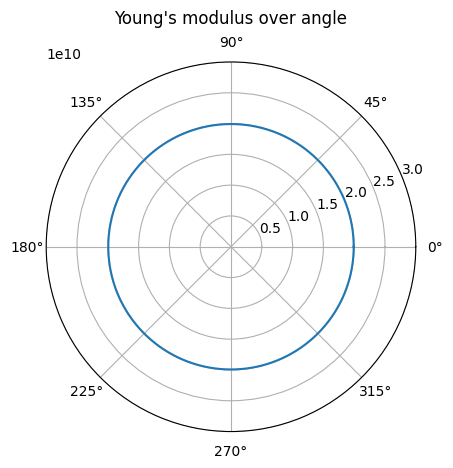

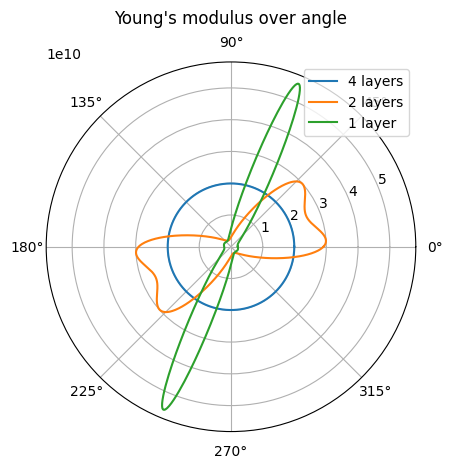

In [6]:
# Halpin-Tsai
E_carbon = 242e9; G_carbon = 105e9; nu_carbon = 0.1; l_carbon = 1.5e-3; 
r_carbon = 7.2 / 2 * 1e-6; vol_carbon = 0.25;
E_pa6 = 1.18e9; G_pa6 = 0.4e9; nu_pa6 = 0.35; 

ht_carbon = HalpinTsai(
        E_carbon,
        E_pa6,
        G_carbon,
        G_pa6,
        nu_carbon,
        nu_pa6,
        l_carbon,
        r_carbon,
        vol_carbon,
    )

laminas = 4*[ht_carbon.get_stiffness()] # individual stiffnesses possible, e.g. [stiffness1, stiffness2, ...]
pi = np.pi
angles = [0, pi/4, -pi/4, pi/2]
laminate1 = Laminate(laminas, angles)

# plot laminate directly via...
plotter.polar_plot_laminate(laminate1.get_effective_stiffness(), 1000, limit=3e10)

laminas = 2*[ht_carbon.get_stiffness()]
angles = [0,pi/4]
laminate2 = Laminate(laminas, angles)

laminas = 1*[ht_carbon.get_stiffness()]
angles=[3/8*pi]
laminate3 = Laminate(laminas, angles)

pHT1 = plotter.polar_plot_laminate(laminate1.get_effective_stiffness(), 1000, plot=False)
pHT2 = plotter.polar_plot_laminate(laminate2.get_effective_stiffness(), 1000, plot=False)
pHT3 = plotter.polar_plot_laminate(laminate3.get_effective_stiffness(), 1000, plot=False)

# ...or plot a collection of laminates
plotter.polar_plot(
    [pHT1 + ("4 layers",), pHT2 + ("2 layers",), pHT3 + ("1 layer",)]
) 

